# Approach

* This is a simplied version of YOLO. We take our 512x512 input, divide it into a 16x16 grid, each cell outputs five values:
    * The confidence that there is pneumonia present
    * The x, y, w, and h of the bounding box
* For labels we have assigned each box to the cell which is in it's center and have assigned the actual x, y, w, and h values to that cell.

# Network

* The network consists of a number of residual blocks with convolutions and downsampling blocks with max pooling.
* The network outputs a 16x16x1 array of confidences and a 16x16x4 array of bounding boxes.
* The confidence cells have a sigmoid activation, the bboxes are linear.
* We use a binary cross entropy loss for the confidence and mean squared error for the bounding boxes.

# Predictions
* To generate our predictions we loop through each cell of the output, if the confidence is greater than 0.5 we append the corresponding bounding box to the prediction string. 

**Note:** Since each pixel only outputs one bounding box there is currently no non-max suppression. We can add this later if neccessary.

**Change Log:**
* v3 - changing output to 8x8 grid from 16x16; changed model to downsample one more time; adjusted network accordingly. 
* v4 - changed output to 4x4 grid, no image has more than 3 ROIs so this may work better? 
    * Using center point of ROI to predict instead of upper left corner.
* v5 - We only calculate MSE loss for boxes with a confidence over 0.5 or actual truth since we don't care about predictions for boxes that are not ROIs. This will prevent the network from being constrained by outputting 0s for boxes that don't exist.
* v6 - centering input data so maybe bboxes can be output more accurately? Also centering the image
* v6.2 - labels have ROI centered in center of cell by default instead of mean location. Weighting MSE loss by confidence + 0.5

In [1]:
import os
import csv
import random
import pydicom
import numpy as np
import pickle
import pandas as pd
from skimage import measure
from skimage.transform import resize
import datetime
import math

import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot as plt
import matplotlib.patches as patches

In [2]:
# Malisiewicz et al.
def non_max_suppression_fast(boxes, overlapThresh=0.3):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
 
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
 
    # initialize the list of picked indexes	
    pick = []
 
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    w = boxes[:,2]
    h = boxes[:,3]
 
    x2 = x1 + w
    y2 = y1 + h

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (w + 1) * (h + 1)
    idxs = np.argsort(y2)
 
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
 
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
 
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
 
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
 
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
 
    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick].astype("int")

In [3]:
# enter your Kaggle credentionals here
os.environ['KAGGLE_USERNAME']="skooch"
os.environ['KAGGLE_KEY']="42f8a02ee92cc773d1dbe66565673ad3"

In [4]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Load pneumonia locations

Table contains [filename : pneumonia location] pairs per row. 
* If a filename contains multiple pneumonia, the table contains multiple rows with the same filename but different pneumonia locations. 
* If a filename contains no pneumonia it contains a single row with an empty pneumonia location.

The code below loads the table and transforms it into a dictionary. 
* The dictionary uses the filename as key and a list of pneumonia locations in that filename as value. 
* If a filename is not present in the dictionary it means that it contains no pneumonia.

In [5]:
ROOT_DIR = "./"

train_dicom_dir = os.path.join(ROOT_DIR, 'stage_1_train_images')
test_dicom_dir = os.path.join(ROOT_DIR, 'stage_1_test_images')
print("Train dir:", train_dicom_dir)

Train dir: ./stage_1_train_images


In [6]:
with open('yolo_labels_centered_4x4_4.p', 'rb') as handle:
    pneumonia_locations = pickle.load(handle)

# Load filenames

In [7]:
random.seed(72)

# load and shuffle filenames
folder = './stage_1_train_images'
filenames = os.listdir(folder)
random.shuffle(filenames)
# split into train and validation filenames
n_valid_samples = int(len(filenames) * 0.1)
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples

n train samples 23116
n valid samples 2568


 # Data generator

The dataset is too large to fit into memory, so we need to create a generator that loads data on the fly.

* The generator takes in some filenames, batch_size and other parameters.

* The generator outputs a random batch of numpy images and numpy masks.
    

In [8]:
BATCH_SIZE = 16
IMAGE_SIZE = 512
CHECKPOINT_PATH = "yolo6_2_512.h5"

In [9]:
# means to center data
mu_x = 391.456158
mu_y = 363.1358768
mu_w = 220.8453815
mu_h = 334.1743641
mu_center_x = 501.8788487
mu_center_y = 530.2230589

In [10]:
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # get filename without extension
        filename = filename.split('.')[0]
        label = pneumonia_locations[filename].copy()
        
        # remove the confidence and bboxes
        confs = label[:,:,0]
        boxes = label[:,:,1:]
        
        ## data augmentation may be complicated, let's do that later
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            # flip the image
            img = np.fliplr(img)
            
            # update our x coords
            mask = confs != 0
            
            # flip
            boxes[mask, 0] = 1024 - boxes[mask,0]
            
            # flip our boxes lr on axis 0
            boxes = np.flip(boxes, axis=0)         
            
            # flip the confidences lr as well
            confs = np.flip(confs, axis=0)
            
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        
        # center the image
        img = img - 0.5
        
        boxes = np.concatenate([confs.reshape((4,4,1)), boxes], axis=2)
        
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img, confs, boxes
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            
            # unzip images and masks
            imgs, confs, bboxes = zip(*items)
            
            # create numpy batch
            imgs = np.array(imgs)
            confs = np.expand_dims(np.array(confs), -1)
            bboxes = np.array(bboxes)
            
            labels = {"confidence_output": confs, "bboxes_output": bboxes}
            return imgs, labels
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

# Network

In [11]:
def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x

def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x_1 = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x_1)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.add([x, x_1])
    return x

def create_network(input_size, channels, n_blocks=2, depth=4):
    # input - 512x512x3
    inputs = keras.Input(shape=(input_size, input_size, 1))
    
    # 256x256x24
    x = keras.layers.Conv2D(channels, 3, strides=(2,2), padding='same', use_bias=False)(inputs)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    
    # 256x256x24 for residual connection
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        
        x = create_downsample(channels, x)
            
        for b in range(n_blocks):
            x = create_resblock(channels, x)
    
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    
    # dilated convolutions for context - 16x16x512
    x_2 = keras.layers.Conv2D(512, (3,3), padding='same', dilation_rate=(2,2), activation=None, name="dilated_conv_1")(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x_2)
    x = keras.layers.LeakyReLU(0.01)(x)
    
    x = keras.layers.Conv2D(512, (3,3), padding='same', dilation_rate=(2,2), activation=None, name="dilated_conv_2")(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0.01)(x)
    
    # downsample to 8x8x512 with stride 2
    x = keras.layers.Conv2D(512, (3,3), padding='same', strides=(2,2), activation=None, name="downsample_1")(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0.01)(x)
    
    # one more 3x3 conv to consolidate - 8x8x512
    x = keras.layers.Conv2D(512, (3,3), padding='same', activation=None, name="last_conv")(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0.01)(x)
    
    # downsample to 4x4x512
    x = keras.layers.MaxPool2D(2)(x)
    
    # confidence branch
    c = keras.layers.Conv2D(768, (1,1), padding='same', activation=None, name="fc_1_c", kernel_regularizer=keras.regularizers.l2(l=0.01))(x)
    c = keras.layers.BatchNormalization(momentum=0.9)(c)
    c = keras.layers.LeakyReLU(0.01)(c)
    c = keras.layers.Dropout(0.25)(c)
    
    c = keras.layers.Conv2D(512, (1,1), padding='same', activation=None, name="fc_2_c", kernel_regularizer=keras.regularizers.l2(l=0.01))(c)
    c = keras.layers.BatchNormalization(momentum=0.9)(c)
    c = keras.layers.LeakyReLU(0.01)(c)
    c = keras.layers.Dropout(0.25)(c)
    
    confidence = keras.layers.Conv2D(1, (1,1), padding='same', activation=None, name="confidence_output")(c)
    
    # bounding box branch
    b = keras.layers.Conv2D(1024, (1,1), padding='same', activation=None, name="fc_1_b", kernel_regularizer=keras.regularizers.l2(l=0.001))(x)
    b = keras.layers.BatchNormalization(momentum=0.9)(b)
    b = keras.layers.LeakyReLU(0.01)(b)
    b = keras.layers.Dropout(0.15)(b)
    
    b = keras.layers.Conv2D(768, (1,1), padding='same', activation=None, name="fc_2_b")(b)
    b = keras.layers.LeakyReLU(0.01)(b)
    b = keras.layers.Dropout(0.05)(b)
    
    b = keras.layers.Conv2D(4, (1,1), padding='same', activation="linear")(b)
    boxes = keras.layers.concatenate([confidence, b], name="bboxes_output")
    
    # return both outputs
    model = keras.Model(inputs=inputs, outputs=[confidence, boxes])
    
    return model

# Train network


In [18]:
# define iou or jaccard loss function
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.4 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.6 * iou_loss(y_true, y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    mean_iou = tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))
    return mean_iou

def adj_mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    y_true_pos = tf.reduce_max(y_true, axis=[1, 2, 3])
    
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

def binary_accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.round(tf.sigmoid(tf.reshape(y_pred, [-1])))
    
    acc = tf.reduce_mean(tf.cast(tf.equal(y_true, y_pred), dtype=tf.float32))
    return acc

# use weight of 0.5 for negative cells, 19 for positive ones
def weighted_binary_cross_entropy(y_true, y_pred):
    weight = 16
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    weights = tf.multiply(tf.cast(weight, tf.float32), tf.cast(tf.greater(y_true, 0), tf.float32)) + 0.5
    xe = tf.losses.sigmoid_cross_entropy(multi_class_labels=y_true, logits=y_pred, weights=weights)
    
    return xe
    
def overlap_iou(y_true, y_pred):
    """
    Args:
        bboxes1: shape (batch_size, 16, 16, 4)
            with x1, y1, x2, y2 point order.
        bboxes2: shape (batch_size, 16, 16, 4)
            with x1, y1, x2, y2 point order.
        p1 *-----
           |     |
           |_____* p2
    Returns:
        Tensor with shape (total_bboxes1, total_bboxes2)
        with the IoU (intersection over union) of bboxes1[i] and bboxes2[j]
        in [i, j].
    """
    # flatten the data because it's easier that way
    bboxes1 = tf.reshape(y_true, (-1, 5))
    bboxes2 = tf.reshape(y_pred, (-1, 5))
    
    # split the components out
    true_boxes, x11, y11, w1, h1 = tf.split(bboxes1, 5, axis=1)
    pred_conf, x21, y21, w2, h2 = tf.split(bboxes2, 5, axis=1)
    
    # uncenter the data - make sure the numbers are positive
    x11 = tf.maximum(x11 + mu_center_x, 0)
    x21 = tf.maximum(x21 + mu_center_x, 0)
    y11 = tf.maximum(y11 + mu_center_y, 0)
    y21 = tf.maximum(y21 + mu_center_y, 0)
    
    w1 = tf.maximum(w1 + mu_w, 0)
    w2 = tf.maximum(w2 + mu_w, 0)
    h1 = tf.maximum(h1 + mu_h, 0)
    h2 = tf.maximum(h2 + mu_h, 0)
    
    # is a box predicted here? maybe use this for the IOU?
    pred_conf = tf.sigmoid(pred_conf)
    mask = (pred_conf >= 0.5) | (true_boxes == 1)
    
    # these labels are center points of the boxes so we need to calculate the corners
    x12 = x11 + (w1 / 2)
    y12 = y11 + (h1 / 2)
    x22 = x21 + (w2 / 2)
    y22 = y21 + (h2 / 2)
    
    x11 = x11 - (w1 / 2)
    y11 = y11 - (h1 / 2)
    x21 = x21 - (w2 / 2)
    y21 = y21 - (h2 / 2)

    # find the corners of the intersection area
    xI1 = tf.maximum(x11, x21)
    yI1 = tf.maximum(y11, y21)

    xI2 = tf.minimum(x12, x22)
    yI2 = tf.minimum(y12, y22)
    
    # get the intersection area, if the truth has no boxes it is 0
    inter_area = true_boxes * (xI2 - xI1 + 1) * (yI2 - yI1 + 1)

    # get the area of each box
    bboxes1_area = (w1 + 1) * (h1 + 1)
    bboxes2_area = (w2 + 1) * (h2 + 1)
    
    # union is area of both boxes - intersection
    union = (bboxes1_area + bboxes2_area) - inter_area + 1
    
    # reduce the mean so we have mean iou for our inputs
    return tf.reduce_mean(tf.maximum(inter_area / union, 0))

# only apply mse to layers with high confidence that there is an ROI or if there actually is an ROI
def adj_mse(y_true, y_pred):
    # flatten the inputs
    y_true = tf.reshape(y_true, (-1, 5))
    y_pred = tf.reshape(y_pred, (-1, 5))
    
    # separate the confidence from the boxes
    conf_pred = y_pred[:,0]
    box_pred = y_pred#[:,1:]
    
    conf_true = y_true[:,0]
    box_true = y_true#[:,1:]
    
    # apply the sigmoid to the predicted confidence
    conf_sigmoid = tf.sigmoid(conf_pred)
    
    # only get loss for boxes which are predicted positive OR are actually positive
    mask = (conf_sigmoid > 0.5) | (conf_true == 1)
    
    # get the MSE
    diff = box_true - box_pred
    diff = tf.square(diff)
    diff = tf.reduce_mean(diff[:,1:], axis=1)
    
    # weight the loss with the sigmoid to weight high probability ROIs more heavily?
    # sigmoid + 0.5 should have range 0.5 to 1.5
    # for some reason this returns nan
#     diff = tf.multiply(diff, tf.add(conf_sigmoid, 0.5))
    
    # apply the mask
    mse = tf.boolean_mask(diff, mask)
    
    # reduce the mean
    mse = tf.reduce_mean(mse)
    
    return mse
    

# create network and compiler
model = create_network(input_size=IMAGE_SIZE, channels=24, n_blocks=1, depth=4)

losses = {
    "confidence_output": weighted_binary_cross_entropy,
    "bboxes_output": adj_mse,
}
lossWeights = { "confidence_output": 1.0, "bboxes_output": 1.0 }

metrics_dict = {
    "confidence_output": binary_accuracy,
    "bboxes_output": [overlap_iou],
}

model.compile(optimizer='adam',
              loss=losses,
              loss_weights=lossWeights,
              metrics=metrics_dict)

# cosine learning rate annealing
def exp_decay(x):
    lr0 = 0.005
    epochs_drop = 7
    drop = 0.75
    lrate = lr0 * math.pow(drop, math.floor((1+x)/epochs_drop))
    return lrate

learning_rate = tf.keras.callbacks.LearningRateScheduler(exp_decay)
checkpoint = keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=True, mode='auto', period=1)

# create train and validation generators
folder = './stage_1_train_images'
train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True, augment=True, predict=False)
valid_gen = generator(folder, valid_filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=False, predict=False)

print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 256, 256, 24) 216         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_32 (BatchNo (None, 256, 256, 24) 96          conv2d_22[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_33 (LeakyReLU)      (None, 256, 256, 24) 0           batch_normalization_32[0][0]     
__________________________________________________________________________________________________
conv2d_23 

In [20]:
model.load_weights(CHECKPOINT_PATH)

In [38]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate, checkpoint], epochs=10, shuffle=True, verbose=1, initial_epoch=3)

Epoch 4/10


/home/eric/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


1443/1444 [============================>.] - ETA: 0s - loss: 891.2529 - confidence_output_loss: 0.4332 - bboxes_output_loss: 874.3724 - confidence_output_binary_accuracy: 0.7518 - bboxes_output_overlap_iou: 0.0079
Epoch 00004: saving model to yolo6_2_512.h5
1444/1444 [==============================] - 883s 611ms/step - loss: 891.4654 - confidence_output_loss: 0.4332 - bboxes_output_loss: 874.5843 - confidence_output_binary_accuracy: 0.7519 - bboxes_output_overlap_iou: 0.0079 - val_loss: 1321.1977 - val_confidence_output_loss: 0.4198 - val_bboxes_output_loss: 1303.9044 - val_confidence_output_binary_accuracy: 0.7604 - val_bboxes_output_overlap_iou: 0.0115
Epoch 5/10
1443/1444 [============================>.] - ETA: 0s - loss: 694.6642 - confidence_output_loss: 0.4238 - bboxes_output_loss: 678.3542 - confidence_output_binary_accuracy: 0.7566 - bboxes_output_overlap_iou: 0.0080
Epoch 00005: saving model to yolo6_2_512.h5
1444/1444 [==============================] - 895s 620ms/step - loss:

In [41]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate, checkpoint], epochs=15, shuffle=True, verbose=1, initial_epoch=10)

Epoch 11/15


/home/eric/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


1443/1444 [============================>.] - ETA: 0s - loss: 293.0204 - confidence_output_loss: 0.4068 - bboxes_output_loss: 284.5959 - confidence_output_binary_accuracy: 0.7617 - bboxes_output_overlap_iou: 0.0081
Epoch 00011: saving model to yolo6_2_512.h5
1444/1444 [==============================] - 877s 607ms/step - loss: 293.0618 - confidence_output_loss: 0.4068 - bboxes_output_loss: 284.6374 - confidence_output_binary_accuracy: 0.7617 - bboxes_output_overlap_iou: 0.0081 - val_loss: 153.6627 - val_confidence_output_loss: 0.3799 - val_bboxes_output_loss: 145.7260 - val_confidence_output_binary_accuracy: 0.7538 - val_bboxes_output_overlap_iou: 0.0119
Epoch 12/15
1443/1444 [============================>.] - ETA: 0s - loss: 274.2436 - confidence_output_loss: 0.4036 - bboxes_output_loss: 266.5300 - confidence_output_binary_accuracy: 0.7657 - bboxes_output_overlap_iou: 0.0082
Epoch 00012: saving model to yolo6_2_512.h5
1444/1444 [==============================] - 903s 625ms/step - loss: 

In [46]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate, checkpoint], epochs=25, shuffle=True, verbose=1, initial_epoch=15)

Epoch 16/25


/home/eric/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


1443/1444 [============================>.] - ETA: 0s - loss: 216.2249 - confidence_output_loss: 0.3897 - bboxes_output_loss: 210.4496 - confidence_output_binary_accuracy: 0.7886 - bboxes_output_overlap_iou: 0.0082
Epoch 00016: saving model to yolo6_2_512.h5
1444/1444 [==============================] - 866s 600ms/step - loss: 216.1663 - confidence_output_loss: 0.3897 - bboxes_output_loss: 210.3912 - confidence_output_binary_accuracy: 0.7886 - bboxes_output_overlap_iou: 0.0082 - val_loss: 160.7993 - val_confidence_output_loss: 0.3629 - val_bboxes_output_loss: 155.3416 - val_confidence_output_binary_accuracy: 0.7899 - val_bboxes_output_overlap_iou: 0.0121
Epoch 17/25
1443/1444 [============================>.] - ETA: 0s - loss: 226.8870 - confidence_output_loss: 0.3784 - bboxes_output_loss: 221.4699 - confidence_output_binary_accuracy: 0.7950 - bboxes_output_overlap_iou: 0.0082
Epoch 00017: saving model to yolo6_2_512.h5
1444/1444 [==============================] - 888s 615ms/step - loss: 

In [101]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate, checkpoint], epochs=30, shuffle=True, verbose=1, initial_epoch=25)

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/eric/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 26/30
1443/1444 [============================>.] - ETA: 0s - loss: 2399.3799 - confidence_output_loss: 0.3479 - bboxes_output_loss: 2395.9550 - confidence_output_binary_accuracy: 0.8220 - bboxes_output_overlap_iou: 0.0087
Epoch 00026: saving model to yolo6_2_512.h5
1444/1444 [==============================] - 947s 656ms/step - loss: 2398.0931 - confidence_output_loss: 0.3479 - bboxes_output_loss: 2394.6684 - confidence_output_binary_accuracy: 0.8220 - bboxes_output_overlap_iou: 0.0087 - val_loss: 935.6607 - val_confidence_output_loss: 0.3425 - val_bboxes_output_loss: 932.1178 - val_confidence_output_binary_accuracy: 0.7777 - val_bboxes_output_overlap_iou: 0.0125
Epoch 27/30
1443/1444 [============================>.] - ETA: 0s - loss: 2398.9420 - confidence_output_loss: 0.3397 - bboxes_output_loss: 2395.2881 - confidence_output_binary_accuracy: 0.8273 - bboxes_output_overlap_iou: 0.0088
Epoch 00027: saving model to yolo6_2_512.h5
1444/1444 [==============================] - 884s 6

In [ ]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate, checkpoint], epochs=40, shuffle=True, verbose=1, initial_epoch=30)

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/eric/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 31/40
1443/1444 [============================>.] - ETA: 0s - loss: 2411.9808 - confidence_output_loss: 0.3320 - bboxes_output_loss: 2407.8294 - confidence_output_binary_accuracy: 0.8456 - bboxes_output_overlap_iou: 0.0093
Epoch 00031: saving model to yolo6_2_512.h5
1444/1444 [==============================] - 969s 671ms/step - loss: 2410.9650 - confidence_output_loss: 0.3319 - bboxes_output_loss: 2406.8136 - confidence_output_binary_accuracy: 0.8456 - bboxes_output_overlap_iou: 0.0093 - val_loss: 1019.7822 - val_confidence_output_loss: 0.3042 - val_bboxes_output_loss: 1015.5337 - val_confidence_output_binary_accuracy: 0.8367 - val_bboxes_output_overlap_iou: 0.0129
Epoch 32/40
1443/1444 [============================>.] - ETA: 0s - loss: 2521.4390 - confidence_output_loss: 0.3274 - bboxes_output_loss: 2516.9509 - confidence_output_binary_accuracy: 0.8520 - bboxes_output_overlap_iou: 0.0092
Epoch 00032: saving model to yolo6_2_512.h5
1444/1444 [==============================] - 898s

In [15]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate, checkpoint], epochs=45, shuffle=True, verbose=1, initial_epoch=38)

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/eric/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 39/45
1443/1444 [============================>.] - ETA: 1s - loss: 2467.7880 - confidence_output_loss: 0.2917 - bboxes_output_loss: 2462.3613 - confidence_output_binary_accuracy: 0.8756 - bboxes_output_overlap_iou: 0.0101
Epoch 00039: saving model to yolo6_2_512.h5
1444/1444 [==============================] - 1884s 1s/step - loss: 2469.4347 - confidence_output_loss: 0.2917 - bboxes_output_loss: 2464.0080 - confidence_output_binary_accuracy: 0.8756 - bboxes_output_overlap_iou: 0.0101 - val_loss: 1466.2522 - val_confidence_output_loss: 0.2713 - val_bboxes_output_loss: 1460.8019 - val_confidence_output_binary_accuracy: 0.9056 - val_bboxes_output_overlap_iou: 0.0130
Epoch 40/45
1443/1444 [============================>.] - ETA: 0s - loss: 2319.9496 - confidence_output_loss: 0.2954 - bboxes_output_loss: 2314.4087 - confidence_output_binary_accuracy: 0.8771 - bboxes_output_overlap_iou: 0.0104
Epoch 00040: saving model to yolo6_2_512.h5
1444/1444 [==============================] - 897s 6

In [21]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate, checkpoint], epochs=60, shuffle=True, verbose=1, initial_epoch=45)

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/eric/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 46/60
1443/1444 [============================>.] - ETA: 0s - loss: 2043.4681 - confidence_output_loss: 0.2868 - bboxes_output_loss: 2037.8873 - confidence_output_binary_accuracy: 0.8817 - bboxes_output_overlap_iou: 0.0111
Epoch 00046: saving model to yolo6_2_512.h5
1444/1444 [==============================] - 901s 624ms/step - loss: 2042.9502 - confidence_output_loss: 0.2868 - bboxes_output_loss: 2037.3693 - confidence_output_binary_accuracy: 0.8817 - bboxes_output_overlap_iou: 0.0111 - val_loss: 1210.3722 - val_confidence_output_loss: 0.2853 - val_bboxes_output_loss: 1204.7509 - val_confidence_output_binary_accuracy: 0.8870 - val_bboxes_output_overlap_iou: 0.0129
Epoch 47/60
1443/1444 [============================>.] - ETA: 0s - loss: 2041.7494 - confidence_output_loss: 0.2864 - bboxes_output_loss: 2036.1288 - confidence_output_binary_accuracy: 0.8846 - bboxes_output_overlap_iou: 0.0112
Epoch 00047: saving model to yolo6_2_512.h5
1444/1444 [==============================] - 887s

1443/1444 [============================>.] - ETA: 0s - loss: 1606.3015 - confidence_output_loss: 0.2702 - bboxes_output_loss: 1600.7267 - confidence_output_binary_accuracy: 0.8957 - bboxes_output_overlap_iou: 0.0122
Epoch 00058: saving model to yolo6_2_512.h5
1444/1444 [==============================] - 886s 613ms/step - loss: 1606.5834 - confidence_output_loss: 0.2702 - bboxes_output_loss: 1601.0085 - confidence_output_binary_accuracy: 0.8957 - bboxes_output_overlap_iou: 0.0122 - val_loss: 1248.9036 - val_confidence_output_loss: 0.2648 - val_bboxes_output_loss: 1243.3346 - val_confidence_output_binary_accuracy: 0.8767 - val_bboxes_output_overlap_iou: 0.0131
Epoch 59/60
1443/1444 [============================>.] - ETA: 0s - loss: 1541.8700 - confidence_output_loss: 0.2696 - bboxes_output_loss: 1536.3036 - confidence_output_binary_accuracy: 0.8933 - bboxes_output_overlap_iou: 0.0124
Epoch 00059: saving model to yolo6_2_512.h5
1444/1444 [==============================] - 885s 613ms/step 

In [24]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate, checkpoint], epochs=75, shuffle=True, verbose=1, initial_epoch=60)

Epoch 61/75


/home/eric/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


1443/1444 [============================>.] - ETA: 0s - loss: 1486.7822 - confidence_output_loss: 0.2687 - bboxes_output_loss: 1481.2382 - confidence_output_binary_accuracy: 0.8956 - bboxes_output_overlap_iou: 0.0124
Epoch 00061: saving model to yolo6_2_512.h5
1444/1444 [==============================] - 886s 614ms/step - loss: 1486.9865 - confidence_output_loss: 0.2688 - bboxes_output_loss: 1481.4424 - confidence_output_binary_accuracy: 0.8956 - bboxes_output_overlap_iou: 0.0124 - val_loss: 1318.4598 - val_confidence_output_loss: 0.2859 - val_bboxes_output_loss: 1312.8925 - val_confidence_output_binary_accuracy: 0.9013 - val_bboxes_output_overlap_iou: 0.0130
Epoch 62/75
1443/1444 [============================>.] - ETA: 0s - loss: 1543.4287 - confidence_output_loss: 0.2648 - bboxes_output_loss: 1537.8858 - confidence_output_binary_accuracy: 0.9006 - bboxes_output_overlap_iou: 0.0125
Epoch 00062: saving model to yolo6_2_512.h5
1444/1444 [==============================] - 886s 613ms/step 

1443/1444 [============================>.] - ETA: 0s - loss: 1299.8403 - confidence_output_loss: 0.2514 - bboxes_output_loss: 1294.4232 - confidence_output_binary_accuracy: 0.9070 - bboxes_output_overlap_iou: 0.0131
Epoch 00073: saving model to yolo6_2_512.h5
1444/1444 [==============================] - 886s 614ms/step - loss: 1300.7615 - confidence_output_loss: 0.2513 - bboxes_output_loss: 1295.3445 - confidence_output_binary_accuracy: 0.9070 - bboxes_output_overlap_iou: 0.0131 - val_loss: 1289.9497 - val_confidence_output_loss: 0.2708 - val_bboxes_output_loss: 1284.5192 - val_confidence_output_binary_accuracy: 0.8862 - val_bboxes_output_overlap_iou: 0.0130
Epoch 74/75
 706/1444 [=============>................] - ETA: 6:55 - loss: 1283.8122 - confidence_output_loss: 0.2591 - bboxes_output_loss: 1278.3955 - confidence_output_binary_accuracy: 0.9087 - bboxes_output_overlap_iou: 0.0129

KeyboardInterrupt: 

/home/eric/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


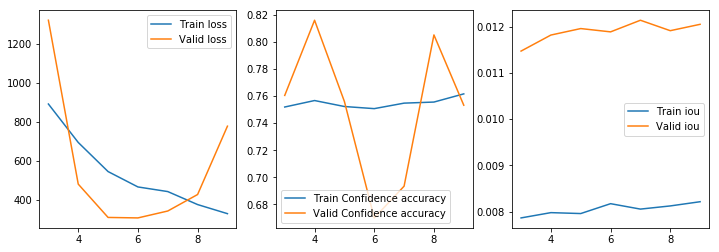

In [39]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["confidence_output_binary_accuracy"], label="Train Confidence accuracy")
plt.plot(history.epoch, history.history["val_confidence_output_binary_accuracy"], label="Valid Confidence accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["bboxes_output_overlap_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_bboxes_output_overlap_iou"], label="Valid iou")
plt.legend()
plt.show()

/home/eric/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


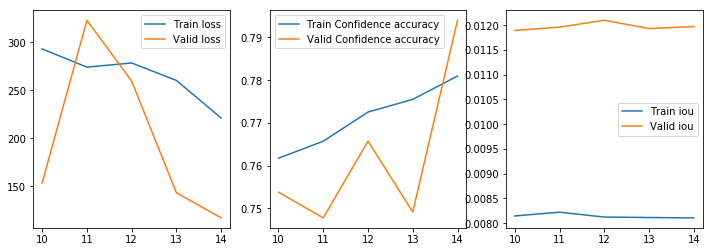

In [42]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["confidence_output_binary_accuracy"], label="Train Confidence accuracy")
plt.plot(history.epoch, history.history["val_confidence_output_binary_accuracy"], label="Valid Confidence accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["bboxes_output_overlap_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_bboxes_output_overlap_iou"], label="Valid iou")
plt.legend()
plt.show()

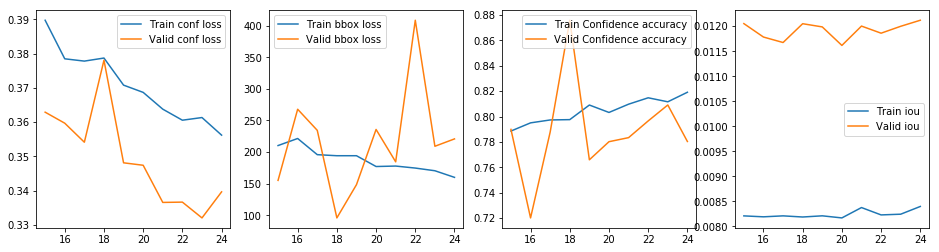

In [50]:
plt.figure(figsize=(16,4))
plt.subplot(141)
plt.plot(history.epoch, history.history["confidence_output_loss"], label="Train conf loss")
plt.plot(history.epoch, history.history["val_confidence_output_loss"], label="Valid conf loss")
plt.legend()
plt.subplot(142)
plt.plot(history.epoch, history.history["bboxes_output_loss"], label="Train bbox loss")
plt.plot(history.epoch, history.history["val_bboxes_output_loss"], label="Valid bbox loss")
plt.legend()
plt.subplot(143)
plt.plot(history.epoch, history.history["confidence_output_binary_accuracy"], label="Train Confidence accuracy")
plt.plot(history.epoch, history.history["val_confidence_output_binary_accuracy"], label="Valid Confidence accuracy")
plt.legend()
plt.subplot(144)
plt.plot(history.epoch, history.history["bboxes_output_overlap_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_bboxes_output_overlap_iou"], label="Valid iou")
plt.legend()
plt.show()

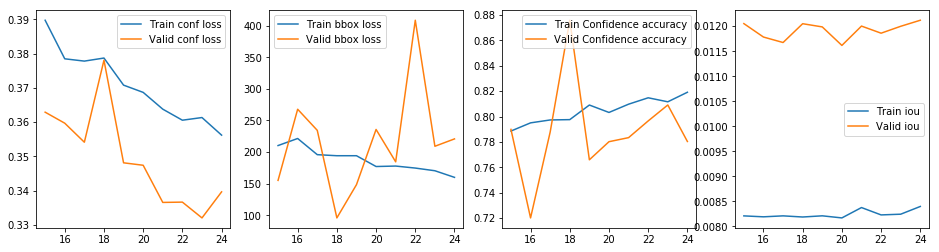

In [60]:
plt.figure(figsize=(16,4))
plt.subplot(141)
plt.plot(history.epoch, history.history["confidence_output_loss"], label="Train conf loss")
plt.plot(history.epoch, history.history["val_confidence_output_loss"], label="Valid conf loss")
plt.legend()
plt.subplot(142)
plt.plot(history.epoch, history.history["bboxes_output_loss"], label="Train bbox loss")
plt.plot(history.epoch, history.history["val_bboxes_output_loss"], label="Valid bbox loss")
plt.legend()
plt.subplot(143)
plt.plot(history.epoch, history.history["confidence_output_binary_accuracy"], label="Train Confidence accuracy")
plt.plot(history.epoch, history.history["val_confidence_output_binary_accuracy"], label="Valid Confidence accuracy")
plt.legend()
plt.subplot(144)
plt.plot(history.epoch, history.history["bboxes_output_overlap_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_bboxes_output_overlap_iou"], label="Valid iou")
plt.legend()
plt.show()

/home/eric/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


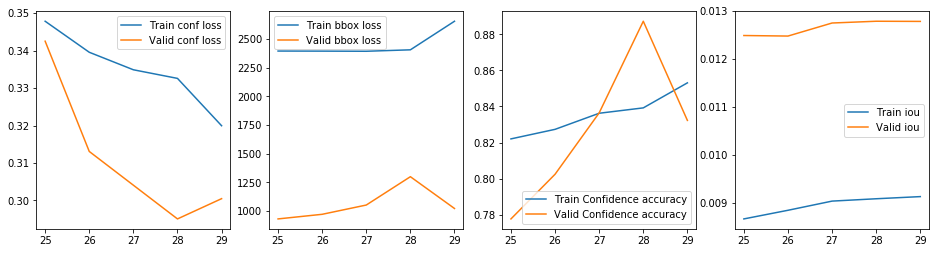

In [102]:
plt.figure(figsize=(16,4))
plt.subplot(141)
plt.plot(history.epoch, history.history["confidence_output_loss"], label="Train conf loss")
plt.plot(history.epoch, history.history["val_confidence_output_loss"], label="Valid conf loss")
plt.legend()
plt.subplot(142)
plt.plot(history.epoch, history.history["bboxes_output_loss"], label="Train bbox loss")
plt.plot(history.epoch, history.history["val_bboxes_output_loss"], label="Valid bbox loss")
plt.legend()
plt.subplot(143)
plt.plot(history.epoch, history.history["confidence_output_binary_accuracy"], label="Train Confidence accuracy")
plt.plot(history.epoch, history.history["val_confidence_output_binary_accuracy"], label="Valid Confidence accuracy")
plt.legend()
plt.subplot(144)
plt.plot(history.epoch, history.history["bboxes_output_overlap_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_bboxes_output_overlap_iou"], label="Valid iou")
plt.legend()
plt.show()

/home/eric/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


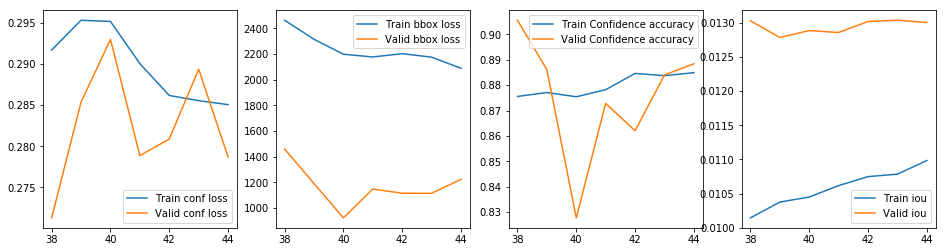

In [16]:
plt.figure(figsize=(16,4))
plt.subplot(141)
plt.plot(history.epoch, history.history["confidence_output_loss"], label="Train conf loss")
plt.plot(history.epoch, history.history["val_confidence_output_loss"], label="Valid conf loss")
plt.legend()
plt.subplot(142)
plt.plot(history.epoch, history.history["bboxes_output_loss"], label="Train bbox loss")
plt.plot(history.epoch, history.history["val_bboxes_output_loss"], label="Valid bbox loss")
plt.legend()
plt.subplot(143)
plt.plot(history.epoch, history.history["confidence_output_binary_accuracy"], label="Train Confidence accuracy")
plt.plot(history.epoch, history.history["val_confidence_output_binary_accuracy"], label="Valid Confidence accuracy")
plt.legend()
plt.subplot(144)
plt.plot(history.epoch, history.history["bboxes_output_overlap_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_bboxes_output_overlap_iou"], label="Valid iou")
plt.legend()
plt.show()

/home/eric/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


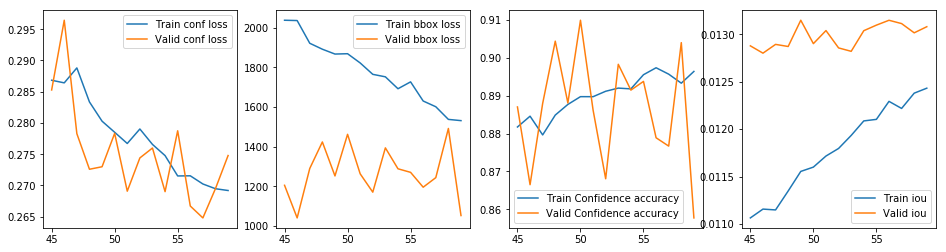

In [22]:
plt.figure(figsize=(16,4))
plt.subplot(141)
plt.plot(history.epoch, history.history["confidence_output_loss"], label="Train conf loss")
plt.plot(history.epoch, history.history["val_confidence_output_loss"], label="Valid conf loss")
plt.legend()
plt.subplot(142)
plt.plot(history.epoch, history.history["bboxes_output_loss"], label="Train bbox loss")
plt.plot(history.epoch, history.history["val_bboxes_output_loss"], label="Valid bbox loss")
plt.legend()
plt.subplot(143)
plt.plot(history.epoch, history.history["confidence_output_binary_accuracy"], label="Train Confidence accuracy")
plt.plot(history.epoch, history.history["val_confidence_output_binary_accuracy"], label="Valid Confidence accuracy")
plt.legend()
plt.subplot(144)
plt.plot(history.epoch, history.history["bboxes_output_overlap_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_bboxes_output_overlap_iou"], label="Valid iou")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(16,4))
plt.subplot(141)
plt.plot(history.epoch, history.history["confidence_output_loss"], label="Train conf loss")
plt.plot(history.epoch, history.history["val_confidence_output_loss"], label="Valid conf loss")
plt.legend()
plt.subplot(142)
plt.plot(history.epoch, history.history["bboxes_output_loss"], label="Train bbox loss")
plt.plot(history.epoch, history.history["val_bboxes_output_loss"], label="Valid bbox loss")
plt.legend()
plt.subplot(143)
plt.plot(history.epoch, history.history["confidence_output_binary_accuracy"], label="Train Confidence accuracy")
plt.plot(history.epoch, history.history["val_confidence_output_binary_accuracy"], label="Valid Confidence accuracy")
plt.legend()
plt.subplot(144)
plt.plot(history.epoch, history.history["bboxes_output_overlap_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_bboxes_output_overlap_iou"], label="Valid iou")
plt.legend()
plt.show()

## Sample Predictions

/home/eric/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Pred: 1 1 conf: 0.7773572288797118
Pred: 1 2 conf: 0.7200147048138653
Pred: 2 1 conf: 0.8820824659463218
Pred: 2 2 conf: 0.8886540409535155
Pred: 2 3 conf: 0.6777774220449349
769 463 224 338
551 463 220 328
261 469 216 318
261 212 222 340
531 218 220 332


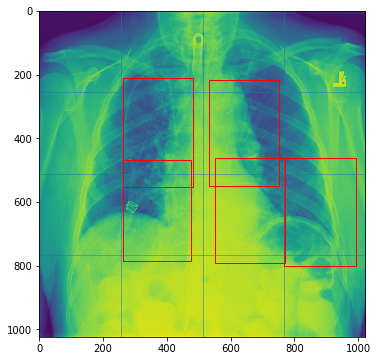

Pred: 2 1 conf: 0.7127192710892062
Pred: 2 2 conf: 0.7279084295435732
270 476 218 326
530 469 220 330


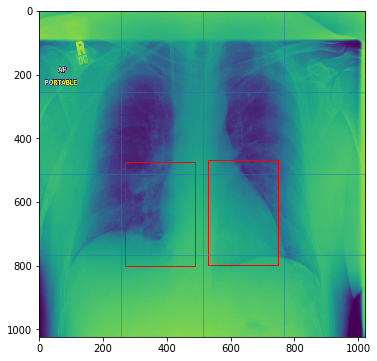

Pred: 1 1 conf: 0.5188567052946083
Pred: 2 1 conf: 0.8958227236802317
Pred: 2 2 conf: 0.7465804014065096
534 470 220 331
268 469 215 315
271 220 222 338


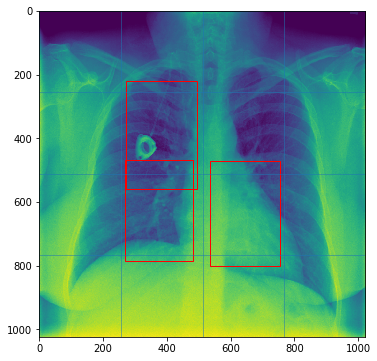

Pred: 1 0 conf: 0.8833869240989163
Pred: 1 2 conf: 0.8194644153184828
Pred: 2 0 conf: 0.5410186814954032
Pred: 2 1 conf: 0.8126054764263896
Pred: 2 2 conf: 0.8719379854630367
260 478 220 328
37 471 219 325
546 469 219 321
27 226 226 352
531 221 219 329


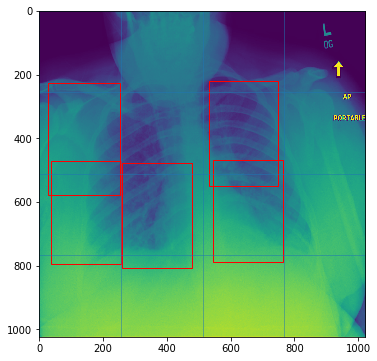

Pred: 1 1 conf: 0.9285371477010275
Pred: 1 2 conf: 0.9442513055601567
Pred: 2 1 conf: 0.8872381827980893
Pred: 2 2 conf: 0.8033391703198608
530 466 220 330
263 468 217 322
249 211 225 362
547 221 221 340


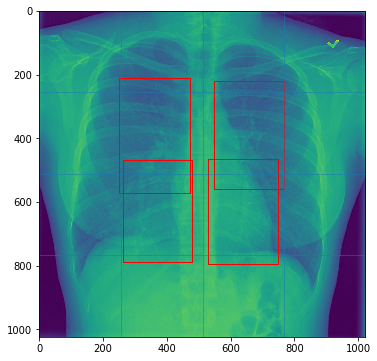

Pred: 1 1 conf: 0.7376745532310726
Pred: 1 3 conf: 0.5445121512081397
Pred: 2 1 conf: 0.9620793675440364
Pred: 2 2 conf: 0.9089279479291813
546 455 221 341
255 462 216 324
751 199 228 374
277 223 223 342


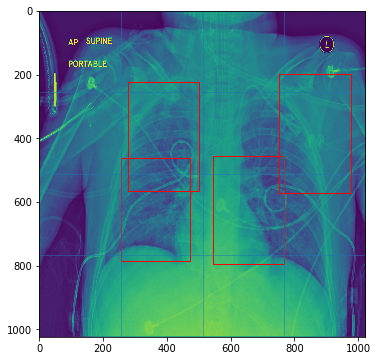

Pred: 1 1 conf: 0.8837716213297275
Pred: 1 2 conf: 0.8000339903967592
Pred: 2 1 conf: 0.8507597168203862
Pred: 2 2 conf: 0.9082740121630519
265 473 218 322
542 464 218 321
270 223 219 332
542 222 220 332


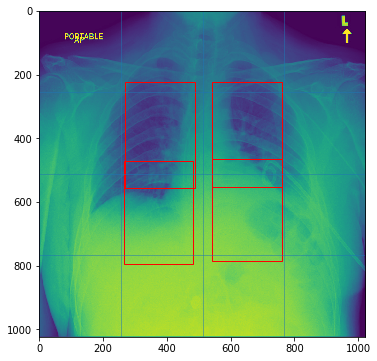

Pred: 1 0 conf: 0.5366306903447285
Pred: 1 1 conf: 0.8798973076509107
Pred: 1 2 conf: 0.727317418724452
Pred: 2 1 conf: 0.895607994699822
Pred: 2 2 conf: 0.9256557630705416
535 460 221 336
265 471 216 317
251 216 223 352
22 224 226 336
536 218 221 337


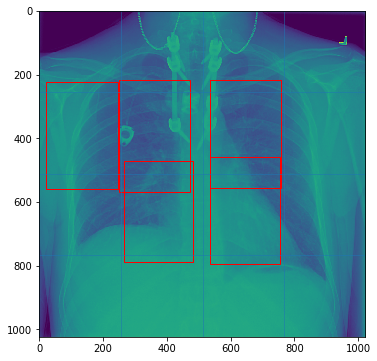

In [23]:
THRESHOLD = 0.5
OVERLAP = 0.3
# look at some sample predictions
samples = np.random.choice(valid_filenames, size=8, replace=False)

coords = np.arange(0, 1024, 256)

for filename in samples:
    # load the image
    img = pydicom.dcmread(os.path.join(train_dicom_dir, filename)).pixel_array
    
    filename = filename.split('.')[0]
    
    f, ax = plt.subplots(figsize=(6, 6))
    plt.imshow(img)
    # get boxes for the truth
    if filename in pneumonia_locations:
        locs = pneumonia_locations[filename]
        for i in range(4):
            for j in range(4):
                pixel_data = locs[i,j,:]
                if pixel_data[0] > 0:
                    x, y, w, h = pixel_data[1:]
                    print("Truth:", i, j)
                    # uncenter the data
#                     x = x + mu_center_x
#                     y = y + mu_center_y
#                     w = w + mu_w
#                     h = h + mu_h
                    
                    # get the corners
                    x = x - (w // 2)
                    y = y - (h // 2)
                    
                    x = int(x)
                    y = int(y)
                    w = int(w)
                    h = int(h)
                    
                    rect = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='b',facecolor='none')
                    ax.add_patch(rect)
    
    # predict the image
    img = resize(img, (IMAGE_SIZE, IMAGE_SIZE), mode='reflect')
    yhat = model.predict(img.reshape(1, IMAGE_SIZE, IMAGE_SIZE, 1))
    
    conf = np.squeeze(yhat[0])
    bboxes = np.squeeze(yhat[1])
    boxes = []
    
    # loop through our predictions
    for i in range(4):
        for j in range(4):
            conf_ = sigmoid(conf[i, j])
            # if we have a prediction
            if conf_ > THRESHOLD:
                _, x,y,w,h = bboxes[i,j,:]
                print("Pred:", i, j, "conf:", conf_)
                # uncenter the coordinates by adding the mean
#                 x = x + mu_center_x
#                 y = y + mu_center_y
#                 w = w + mu_w
#                 h = h + mu_h
                
                # convert to upper left corner from center
                x = x - (w // 2)
                y = y - (h // 2)
                
                x = int(x)
                y = int(y)
                w = int(w)
                h = int(h)

                # if the boxes have width and height
                if w > 5 and h > 5:
                    boxes.append([x,y,w,h])
    
    # do non-max suppression of our boxes
    boxes = non_max_suppression_fast(np.array(boxes), OVERLAP)
    
    # plot our boxes
    for box in boxes:
        x,y,w,h = box
        print(x, y, w, h)
        rect = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    
    for item in coords:
        plt.axvline(item, linewidth=0.5)
        plt.axhline(item, linewidth=0.5)
    
    plt.show()

# Predict test images

In [ ]:
THRESHOLD = 0.5

# load and shuffle filenames
folder = './stage_1_test_images'
test_filenames = os.listdir(folder)
print('n test samples:', len(test_filenames))

# create test generator with predict flag set to True
test_gen = generator(folder, test_filenames, None, batch_size=3, image_size=IMAGE_SIZE, shuffle=False, predict=True)

# create submission dictionary
submission_dict = {}
# loop through testset
for imgs, filenames in test_gen:
    
    # predict batch of images
    conf_preds, bbox_preds = model.predict(imgs)
    
    # loop through batch
    for confs, bboxes, filename in zip(conf_preds, bbox_preds, filenames):
        predictionString = ""
        print(filename)
        boxes = []
        for i in range(4):
            for j in range(4):
                conf = sigmoid(confs[i, j, 0])
                if conf > THRESHOLD:
                    x, y, w, h = bboxes[i,j]
                    
                    # possible thresholds to keep our boxes within reasonable sizes?
                    if True: #w < 600 and h < 1000:
                        # uncenter the coordinates by adding the mean
#                         x = x + mu_center_x
#                         y = y + mu_center_y
#                         w = w + mu_w
#                         h = h + mu_h
                        
                        # convert to upper left corner from center
                        x = x - (w // 2)
                        y = y - (h // 2)
                       
                        # cast to ints
                        x = int(x)
                        y = int(y)
                        w = int(w)
                        h = int(h)
                        
                        if w > 20 and h > 20:
                            # make sure our boxes don't run off the edges of the images
                            w = np.minimum(w, 1024 - x)
                            h = np.minimum(h, 1024 - y)
                            boxes.append([x,y,w,h])

        # do our non-max suppression here
        boxes = non_max_suppression_fast(np.array(boxes), 0.3)
        
        # loop through our suppressed boxes and creat the prediction string
        for box in boxes:
            x,y,w,h = box
            # create the prediction string
            predictionString += str(conf) + ' ' + str(x) + ' ' + str(y) + ' ' + str(w) + ' ' + str(h) + ' '
            
        # add filename and predictionString to dictionary
        filename = filename.split('.')[0]
        submission_dict[filename] = predictionString

    # stop if we've got them all
    if len(submission_dict) >= len(test_filenames):
        break
    break
    
# save dictionary as csv file
sub = pd.DataFrame.from_dict(submission_dict,orient='index')
sub.index.names = ['patientId']
sub.columns = ['PredictionString']

now = datetime.datetime.now()
today = str(now)[:10]
submission_file = today + "_yolo_submission.csv" 
sub.to_csv(submission_file)

In [19]:
!kaggle competitions submit -c rsna-pneumonia-detection-challenge -f submission.csv -m "YOLOv6 512x512 10 epochs"

Successfully submitted to RSNA Pneumonia Detection Challenge

In [20]:
save_file_to_drive("submission.csv", "submission.csv")
save_file_to_drive(CHECKPOINT_PATH, CHECKPOINT_PATH)

File ID: 1GGJOHEa4uJTtlo-cvF2NLYjCbKp6hq3_
File ID: 1C7SXJVn51_rnrx8bU_1v8k-zeFhHybkJ


{'id': '1C7SXJVn51_rnrx8bU_1v8k-zeFhHybkJ'}

In [21]:
# upload checkpoint to GCS
project_id = 'mammography-198911'
bucket_name = 'pneumonia'

!gcloud config set project {project_id}
!gsutil cp ./{CHECKPOINT_PATH} gs://{bucket_name}/

Updated property [core/project].
Copying file://./model7_448.h5 [Content-Type=application/octet-stream]...
|
Operation completed over 1 objects/93.8 MiB.                                     


In [19]:
# upload checkpoint to GCS
project_id = 'mammography-198911'
bucket_name = 'pneumonia'

!gcloud config set project {project_id}

Updated property [core/project].


In [20]:
!gsutil cp ./yolo_labels.p gs://{bucket_name}/

Copying file://./yolo_labels.p [Content-Type=text/x-pascal]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

ResumableUploadAbortException: 403 Insufficient Permission
